In [15]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

from torch import tensor
from torchvision import transforms
from torch.utils.data import Dataset

In [2]:
with open('data/annotations/train.json', 'r') as f:
    data = json.load(f)

In [5]:
df = pd.DataFrame(data['annotations'])
print(df.shape)
df.head()

(87106, 3)


,image_id,bbox,category_id
0,318219,"[505.24, 0.0, 47.86, 309.25]",72
1,318219,"[470.68, 0.0, 45.93, 191.86]",72
2,318219,"[442.51, 0.0, 43.39, 119.87]",72
3,554625,"[380.74, 112.85, 40.62, 248.82]",72
4,554625,"[339.13, 32.99, 32.99, 175.5]",72


In [6]:
id2img = {d['id']:f'data/train_images/{d['file_name']}' for d in data['images']}

cat_id2id = {d['id']:i for i, d in enumerate(data['categories'])}
id2label = {i:d['name'] for i, d in enumerate(data['categories'])}
df.category_id = df.category_id.replace(cat_id2id)

In [7]:
agg_df = df.groupby('image_id').agg(list).reset_index()

In [8]:
img_id, boxes, ids = [*agg_df.loc[3]]
img = Image.open(id2img[img_id])
draw = ImageDraw.Draw(img)
labels = [id2label[id] for id in ids]

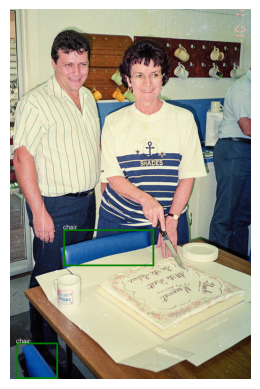

In [9]:
for label, box in zip(labels, boxes):
    x_min, y_min, w, h = box
    draw.rectangle(((x_min, y_min), (x_min+w, y_min+h)), outline="green", width=3)
    draw.text((x_min, y_min-10), label, fill="white")

plt.imshow(img)
plt.axis('off')
plt.show()

In [16]:
class ObjectDataset(Dataset):
    def __init__(self, df, tfms=None):
        self.df = df.groupby('image_id').agg(list).reset_index()
        self.tfms = tfms

    def __len__(self):
        return len(self.df)
        
    def __getitem__(self, idx):
        img_id, boxes, ids = [*self.df.loc[idx]]
        img = Image.open(id2img[img_id])
        if self.tfms:
            img = self.tfms(img)
        boxes, ids = tensor(boxes), tensor(ids)
        return img, boxes, ids

    def show(self, idx):
        img_id, boxes, ids = [*self.df.loc[idx]]
        img = Image.open(id2img[img_id])
        draw = ImageDraw.Draw(img)
        labels = [id2label[id] for id in ids]
        
        for label, box in zip(labels, boxes):
            x_min, y_min, w, h = box
            draw.rectangle(((x_min, y_min), (x_min+w, y_min+h)), outline="green", width=3)
            draw.text((x_min, y_min-10), label, fill="white")
        plt.imshow(img)
        plt.axis('off')
        plt.show()

In [12]:
img_sizes = pd.DataFrame(
    [Image.open(id2img[id]).size for id in agg_df.image_id],
    columns=['width','height']
)
img_sizes.describe()

,width,height
count,21837.000000,21837.000000
mean,575.685763,481.714201
std,90.947749,94.845737
min,119.000000,102.000000
25%,500.000000,426.000000
50%,640.000000,480.000000
75%,640.000000,500.000000
max,640.000000,640.000000


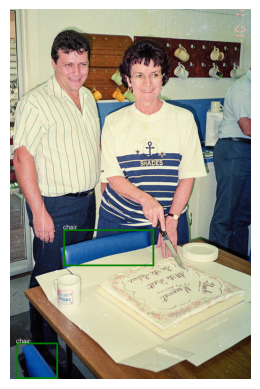

In [17]:
tfms = transforms.Compose([
    transforms.Resize((640, 480)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

ds = ObjectDataset(df, transforms=tfms)
ds.show(3)

In [18]:
ds[3]

(tensor([[[ 1.1015,  1.1187,  1.0331,  ...,  0.5022,  0.4337,  0.2796],
          [ 0.2967,  0.4508,  0.6221,  ...,  0.5364,  0.3652,  0.4337],
          [-1.3815, -1.3644, -1.3473,  ...,  0.4337,  0.3652,  0.2796],
          ...,
          [-1.0219, -0.8849, -0.6623,  ..., -1.0904, -1.1760, -1.1760],
          [-1.0904, -1.0562, -1.0733,  ..., -1.1932, -1.1760, -1.0048],
          [-1.1075, -1.1760, -1.0390,  ..., -1.1760, -1.0562, -1.1075]],
 
         [[ 1.4657,  1.4307,  1.4482,  ...,  1.0630,  1.0105,  0.9055],
          [ 0.7479,  0.7829,  0.9930,  ...,  0.9580,  0.9580,  0.9230],
          [-1.2479, -1.3354, -1.3179,  ...,  0.8529,  0.8179,  1.0280],
          ...,
          [-0.6877, -0.3725, -0.3025,  ..., -1.2129, -1.2829, -1.3529],
          [-0.6176, -0.7227, -0.7402,  ..., -1.3179, -1.2479, -1.1429],
          [-0.8277, -0.5826, -0.5476,  ..., -1.1604, -1.0728, -1.3704]],
 
         [[ 1.0539,  1.1759,  1.2631,  ...,  0.9319,  0.9145,  0.8797],
          [ 0.7576,  0.9494,

In [9]:
def get_iou(boxA, boxB, epsilon=1e-5):
    x_min = max(boxA[0], boxB[0])
    y_min = max(boxA[1], boxB[1])
    x_max = min(boxA[0]+boxA[2], boxB[0]+boxB[2])
    y_max = min(boxA[1]+boxA[3], boxB[1]+boxB[3])
    w, h = x_max-x_min, y_max-y_min

    if w<0 or h<0: return 0
    intersection = w*h
    union = boxA[2]*boxA[3] + boxB[2]*boxB[3] - intersection
    return intersection/(union+epsilon)